In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

Using device: cuda
Epoch [0/3000], Training Loss: 0.5991, Validation Loss: 0.6923
Epoch [100/3000], Training Loss: 0.5629, Validation Loss: 0.7398
Epoch [200/3000], Training Loss: 0.5605, Validation Loss: 0.7317
Epoch [300/3000], Training Loss: 0.5599, Validation Loss: 0.7225
Epoch [400/3000], Training Loss: 0.5616, Validation Loss: 0.7311
Epoch [500/3000], Training Loss: 0.5619, Validation Loss: 0.7231
Epoch [600/3000], Training Loss: 0.5602, Validation Loss: 0.7293
Epoch [700/3000], Training Loss: 0.5603, Validation Loss: 0.7516
Epoch [800/3000], Training Loss: 0.5614, Validation Loss: 0.7429
Epoch [900/3000], Training Loss: 0.5608, Validation Loss: 0.7345
Epoch [1000/3000], Training Loss: 0.5632, Validation Loss: 0.7188
Epoch [1100/3000], Training Loss: 0.5648, Validation Loss: 0.7398
Epoch [1200/3000], Training Loss: 0.5596, Validation Loss: 0.7277
Epoch [1300/3000], Training Loss: 0.5618, Validation Loss: 0.7308
Epoch [1400/3000], Training Loss: 0.5599, Validation Loss: 0.7184
Epo

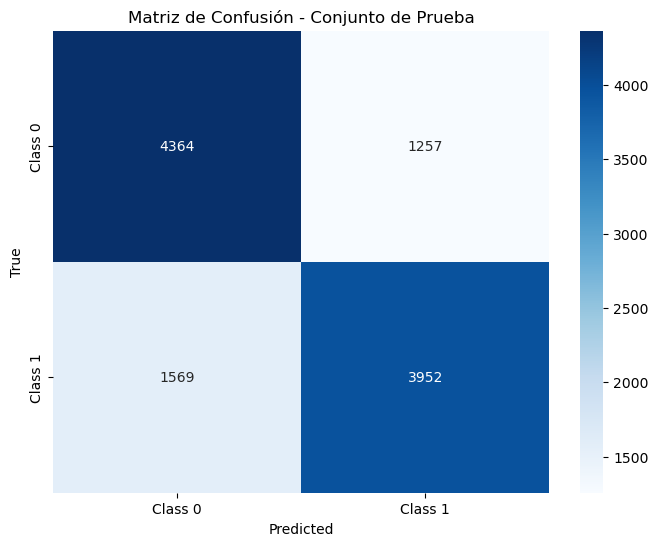

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from scipy.sparse.linalg import norm
from scipy.stats import zscore
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import re

#####################################
# Configuración de entorno y datos
#####################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv", sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv", sep=";")

train_data = train_data.dropna(subset=['Texto', 'Label'])
val_data = val_data.dropna(subset=['Texto', 'Label'])
test_data = test_data.dropna(subset=['Texto', 'Label'])

X_train = train_data['Texto']
y_train = train_data['Label']

X_val = val_data['Texto']
y_val = val_data['Label']

X_test = test_data['Texto']
y_test = test_data['Label']

#####################################
# Preprocesamiento de texto
#####################################

X_train_clean = X_train.str.lower().str.replace('[^a-zA-Z]', ' ', regex=True)
X_val_clean = X_val.str.lower().str.replace('[^a-zA-Z]', ' ', regex=True)
X_test_clean = X_test.str.lower().str.replace('[^a-zA-Z]', ' ', regex=True)

tfidf_vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 3), max_features=15000, stop_words='english')
X_train_vec = tfidf_vectorizer_ngrams.fit_transform(X_train_clean)
X_val_vec = tfidf_vectorizer_ngrams.transform(X_val_clean)
X_test_vec = tfidf_vectorizer_ngrams.transform(X_test_clean)

selector = SelectKBest(chi2, k=5000)
X_train_reduced = selector.fit_transform(X_train_vec, y_train)
X_val_reduced = selector.transform(X_val_vec)
X_test_reduced = selector.transform(X_test_vec)

scaler = StandardScaler(with_mean=False)
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_val_normalized = scaler.transform(X_val_reduced)
X_test_normalized = scaler.transform(X_test_reduced)

row_norms = norm(X_train_normalized, axis=1)
z_scores = zscore(row_norms)
mask = np.abs(z_scores) < 3.0
X_train_cleaned = X_train_normalized[mask]
y_train_cleaned = y_train[mask]

X_train_tensor = torch.tensor(X_train_cleaned.toarray(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_cleaned.values, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val_normalized.toarray(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_normalized.toarray(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

#####################################
# Definición del modelo (logística)
#####################################

class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train_tensor.shape[1]
model = LogisticRegressionTorch(input_dim).to(device)

criterion = nn.BCELoss()

#####################################
# Parámetros de entrenamiento
#####################################

learning_rate = 0.005
momentum = 0.9
epochs = 3000
batch_size = 64
weight_decay = 1e-4

#####################################
# Función de actualización MBGD con momentum + L2
#####################################
def mbgd_momentum_step(model, velocities, lr=0.005, momentum=0.9, wd=1e-4):
    with torch.no_grad():
        for param, v in zip(model.parameters(), velocities):
            if param.grad is not None:
                param.grad.add_(param, alpha=wd)  # L2 regularization
                v.mul_(momentum).add_(param.grad, alpha=-lr)
                param.add_(v)

velocities = [torch.zeros_like(param, device=device) for param in model.parameters()]

n_samples = X_train_tensor.shape[0]

# Entrenar el número total de épocas, sin early stopping
for epoch in range(epochs):
    indices = torch.randperm(n_samples, device=device)
    X_train_shuffled = X_train_tensor[indices]
    y_train_shuffled = y_train_tensor[indices]

    epoch_loss = 0.0
    model.train()

    for i in range(0, n_samples, batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        model.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        mbgd_momentum_step(model, velocities, lr=learning_rate, momentum=momentum, wd=weight_decay)
        epoch_loss += loss.item()

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor).squeeze()
            val_loss = criterion(val_outputs, y_val_tensor).item()
        avg_loss = epoch_loss / (n_samples / batch_size)
        print(f"Epoch [{epoch}/{epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Después del entrenamiento, no se guarda el mejor modelo ya que no hubo early stopping.
# Simplemente se evalúa el modelo tal cual quedó al final de las 3000 épocas.
model.eval()

with torch.no_grad():
    val_outputs = model(X_val_tensor).squeeze()
    val_probs = val_outputs.cpu().numpy()
    y_val_np = y_val_tensor.cpu().numpy()

candidate_thresholds = np.arange(0.05, 1.0, 0.05)
threshold_candidates = []
for t in candidate_thresholds:
    val_predictions = (val_probs > t).astype(np.float32)
    p = precision_score(y_val_np, val_predictions)
    f1 = f1_score(y_val_np, val_predictions)
    threshold_candidates.append((t, p, f1))

filtered = [(t, p, f1) for t, p, f1 in threshold_candidates if p >= 0.76]

if len(filtered) == 0:
    filtered = sorted(threshold_candidates, key=lambda x: x[1], reverse=True)
    best_threshold, best_precision, best_f1 = filtered[0]
    print("No se encontró un umbral con precisión >= 0.76. Se elige el umbral con mayor precisión posible.")
else:
    filtered = sorted(filtered, key=lambda x: x[2], reverse=True)
    best_threshold, best_precision, best_f1 = filtered[0]

print(f"Umbral seleccionado: {best_threshold:.2f}, Precision: {best_precision:.4f}, F1: {best_f1:.4f}")

val_predictions = (val_probs > best_threshold).astype(np.float32)
val_precision = precision_score(y_val_np, val_predictions)
val_accuracy = accuracy_score(y_val_np, val_predictions)
val_f1 = f1_score(y_val_np, val_predictions)
val_conf_matrix = confusion_matrix(y_val_np, val_predictions)

print("\nValidation Metrics (con umbral seleccionado):")
print(f"Precision: {val_precision:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print("Confusion Matrix:\n", val_conf_matrix)

with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_probs = test_outputs.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

test_predictions = (test_probs > best_threshold).astype(np.float32)
test_precision = precision_score(y_test_np, test_predictions)
test_accuracy = accuracy_score(y_test_np, test_predictions)
test_f1 = f1_score(y_test_np, test_predictions)
test_conf_matrix = confusion_matrix(y_test_np, test_predictions)

print("\nTest Metrics (con umbral seleccionado):")
print(f"Precision: {test_precision:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("Confusion Matrix:\n", test_conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
